## CutMix Implementation for Generating Datasets

#### Citation: 
Yun, S., Han, D., Oh, S., Chun, S., Choe, J., & Yoo, Y. (2019). CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features. In International Conference on Computer Vision (ICCV).

In [1]:
from ast import literal_eval
import boto3
import os
import pandas as pd
from glob import glob
from pathlib import Path
from collections import Counter 
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import pickle
import datetime
import logging

pd.set_option('display.max_rows', 500)

#### Download the CIFAR10 dataset, normalize it, and place into a PyTorch DataLoader

In [2]:
normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                 std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
my_transforms = transforms.Compose([transforms.ToTensor(), normalize])

dataset = datasets.CIFAR10("data", download=True,
                 train=True, transform=transforms.ToTensor())

dataloader = torch.utils.data.DataLoader(dataset, batch_size=100) 
len(dataloader)

Extracting data/cifar-10-python.tar.gz to data


500

#### Functions that implement CutMix

In [3]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2


def cutmix_ds(beta, cutmix_prob, my_dataloader):
    log_file = '/home/ec2-user/SageMaker/cifar10_cm_beta'+str(beta)+'_prob'+str(cutmix_prob)+'.log'
    logging.basicConfig(filename=log_file,level=logging.DEBUG)
    logger = logging.getLogger()
    results = []
    label_one = np.array([])
    label_two = np.array([])
    lambdas = np.array([])

    for i, (input, target) in enumerate(my_dataloader):
        # measure run time
        start = datetime.datetime.now()

        r = np.random.rand(1)
        if beta > 0 and r < cutmix_prob:
            # generate mixed sample
            lam = np.random.beta(beta, beta)
            rand_index = torch.randperm(input.size()[0])
            target_a = target
            target_b = target[rand_index]
            bbx1, bby1, bbx2, bby2 = rand_bbox(input.size(), lam)
            input[:, :, bbx1:bbx2, bby1:bby2] = input[rand_index, :, bbx1:bbx2, bby1:bby2]

            # adjust lambda to exactly match pixel ratio
            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (input.size()[-1] * input.size()[-2]))

            results.append(input)
            label_one = np.append(label_one, target_a.numpy())
            label_two = np.append(label_two, target_b.numpy())
            lambdas = np.append(lambdas, np.repeat(lam, len(target_b.numpy())))
        else:
            results.append(input)
            label_one = np.append(label_one, target.numpy())
            label_two = np.append(label_two, np.repeat(0, len(target.numpy())))
            lambdas = np.append(lambdas, np.repeat(1.0, len(target.numpy())))
            
            
        end = datetime.datetime.now()
        d = end - start
        mssg = "  Batch " + str(i) + '  Processing Time: ' + str(d) + ' seconds'
        logger.debug(mssg)
                
    flat_results = [item for items in results for item in items]            
    my_labels = [(l1, l2, l) for l1, l2, l in zip(label_one, label_two, lambdas)]
    
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)
        
        
    return flat_results, my_labels 

#### Generate Datasets

In [55]:
cm_data1, cm_labels1 = cutmix_ds(1.0, 1.0, dataloader)
cm_data2, cm_labels2 = cutmix_ds(1.0, 0.5, dataloader)
cm_data3, cm_labels3 = cutmix_ds(1.0, 0.25, dataloader)
cm_data4, cm_labels4 = cutmix_ds(1.0, 1.5, dataloader)

In [56]:
print(len(cm_labels1), len(cm_data1))

50000 50000


### Save and Load the PyTorch Data

In [6]:
base_dir = '/home/ec2-user/SageMaker/'
base_filename = 'cifar10_cm_beta1_prob1.5'

data_file = base_filename + '_data.pt'
data_full = base_dir + data_file
labels_file = base_filename + '_labels.npy'
labels_full = base_dir + labels_file

torch.save(cm_data1, data_full)
np.save(labels_full, cm_labels1)

In [7]:
# Upload the files to S3
bucket='sagemaker-june29'
prefix = 'sagemaker/CutMix/'
path = '/home/ec2-user/SageMaker/'

s3_resource = boto3.resource("s3", region_name="us-east-2")
my_bucket = s3_resource.Bucket(bucket)
my_bucket.upload_file(data_full, prefix + data_file)
my_bucket.upload_file(labels_full, prefix + labels_file)

#### Verify Data

In [41]:
my_load = torch.load('/home/ec2-user/SageMaker/cifar10_cm_beta1_prob1_data.pt')
my_label = np.load('/home/ec2-user/SageMaker/cifar10_cm_beta1_prob1_labels.npy', allow_pickle=True)
print(len(my_load), len(my_label))

50000 50000


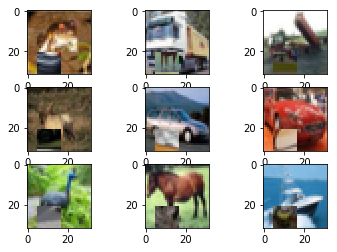

In [17]:
for i in range(9):
    plt.subplot(330 + 1 + i)
    img = cm_data[i]
    image=torch.squeeze(img)
    image=transforms.ToPILImage()(image)
    plt.imshow(image)
# show the figure
plt.show()